In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import fem, sys, os, time, Bio.PDB, nglview, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
#data_dir = '../../../data/msa'
data_dir = 'Pfam_data'
sys.path.append(data_dir)
from parse_pfam import parse_pfam
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
%matplotlib inline
#from ipymol import viewer
#viewer.start()
#pymol = viewer._server

In [2]:
pfam, pdb_refs = parse_pfam(data_dir)
print 'total MSAs: %i, total PDB refs: %i' % (pfam.shape[0], pdb_refs.shape[0])

total MSAs: 17772, total PDB refs: 249704


In [3]:
pfam['size'] = pfam['res'] * pfam['seq']
pfam.sort_values(by='size', ascending=False, inplace=True)
pfam.head()

,res,seq,pdb_refs,size
PF00005,2380,681506,573,1621984280
PF07690,3604,375867,23,1354624668
PF00069,3301,349448,4505,1153527848
PF00067,5109,132516,913,677024244
PF00501,3982,157533,208,627296406


In [4]:
# Cas 9 family accesion code
ac = 'PF16592'
# store the family of interest in the 'fam' variable
fam = pfam.loc[ac]
print 'size rank: %i of %i' % (pfam['size'].rank(ascending=False)[fam.name].astype(int), pfam.shape[0])

# local directory containing data for this MSA
fam_dir = os.path.join(data_dir, 'Pfam-A.full', fam.name)
# the residue symbols array that is the MSA
msa = np.load(os.path.join(fam_dir, 'msa.npy'))

# determine which residues are the same across all sequences, excluding gaps
aa = np.array([np.unique(s) for s in msa])
one_aa = np.array([len(a) == 1 for a in aa])
two_aa = np.array([len(a) == 2 for a in aa])
missing_aa_res = np.array(['-' in a for a in aa])
conserved_residues = one_aa | (two_aa & missing_aa_res)

# the number of unique amino acids (or gap symbol) that appear at each residue
m = np.array([len(a) for a in aa])
m = m[~conserved_residues]
n_residues = m.shape[0]

pfam[pfam.index == ac]

size rank: 7350 of 17772


,res,seq,pdb_refs,size
PF16592,1265,227,25,287155


In [22]:
print(msa.shape)

(1265, 227)


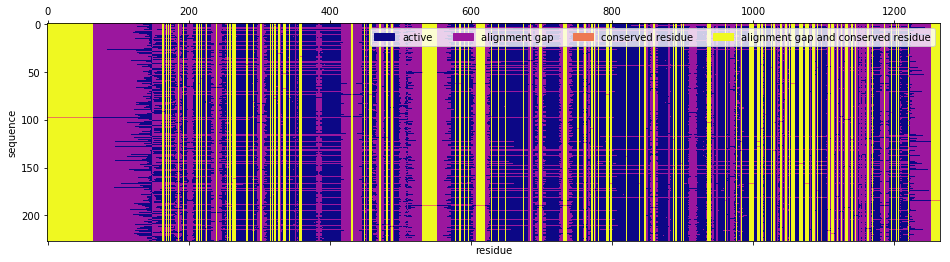

In [5]:
code = np.zeros(msa.shape, dtype=int)
code[conserved_residues] = 2
for j, s in enumerate(msa.T):
    code[s == '-', j] += 1

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.set_ylabel('sequence')
ax.set_xlabel('residue')
cmap = plt.cm.get_cmap('plasma', 4)
ax.matshow(code.T, aspect='auto', cmap=cmap)
labels = ['active', 'alignment gap', 'conserved residue', 'alignment gap and conserved residue']
handles = [patches.Patch(color=cmap(i), label=labels[i]) for i in range(4)]
plt.legend(handles=handles, ncol=4)
plt.show()

fit time: 29.78 sec


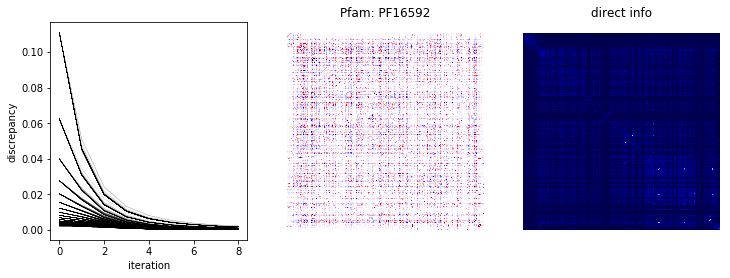

In [6]:
def direct_information(msa, cache=True):

    w_file = os.path.join(fam_dir, 'w.npy')
    disc_file = os.path.join(fam_dir, 'disc.npy')
    if cache and os.path.exists(w_file) and os.path.exists(disc_file):
        w = np.load(w_file)
        disc = np.load(disc_file)
    else:
        model = fem.discrete.model()
        start = time.time()
        model.fit(msa[~conserved_residues], iters=10)
        end = time.time()
        print 'fit time: %.02f sec' % (end-start,)
        w = np.hstack(model.w.values())
        disc = model.disc
        np.save(w_file, w)
        np.save(disc_file, disc)

    direct_info_file = os.path.join(fam_dir, 'direct_info.npy')
    if cache and os.path.exists(direct_info_file):
        direct_info = np.load(direct_info_file)
    else:
        mm = np.insert(m.cumsum(), 0, 0)
        w_idx = np.vstack((mm[:-1], mm[1:])).T
        direct_info = np.zeros((n_residues, n_residues))
        for i, ii in enumerate(w_idx):
            for j, jj in enumerate(w_idx):
                p = np.exp(w[ii[0]:ii[1], jj[0]:jj[1]])
                pi, pj = p.sum(axis=1), p.sum(axis=0)
                p /= p.sum()
                pi /= pi.sum()
                pj /= pj.sum()
                direct_info[i,j] = (p*np.log(p/np.outer(pi, pj))).sum()
        np.save(direct_info_file, direct_info)

    return direct_info, w, disc

direct_info, w, disc = direct_information(msa, cache=False)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for d in disc:
    ax[0].plot(d, 'k-', lw=0.1)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('discrepancy')
scale = 1e-1 * np.abs(w).max()
ax[1].matshow(w, cmap='seismic', vmin=-scale, vmax=scale)
ax[1].set_title('Pfam: %s' % (fam.name,))
scale = 1e-1 * np.abs(direct_info).max()
ax[2].matshow(direct_info, cmap='seismic', vmin=0, vmax=scale)
ax[2].set_title('direct info')
for a in ax[1:]:
    a.axis('off')
plt.show()

In [7]:
refs = pdb_refs[pdb_refs.index.str.contains(fam.name)]
refs.head()

,seq,uniprot_id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end
PF16592,100,CAS9_STRP1,181,712,5FQ5,B,181,712
PF16592,100,CAS9_STRP1,181,712,5Y36,A,181,712
PF16592,100,CAS9_STRP1,181,712,5FW3,B,181,712
PF16592,100,CAS9_STRP1,181,712,4CMP,A,181,712
PF16592,100,CAS9_STRP1,181,712,4ZT9,C,181,712


In [8]:
print(refs.shape[0])

19


In [9]:
print(refs)

         seq  uniprot_id  uniprot_start  uniprot_end pdb_id chain  pdb_start  \
PF16592  100  CAS9_STRP1            181          712   5FQ5     B        181   
PF16592  100  CAS9_STRP1            181          712   5Y36     A        181   
PF16592  100  CAS9_STRP1            181          712   5FW3     B        181   
PF16592  100  CAS9_STRP1            181          712   4CMP     A        181   
PF16592  100  CAS9_STRP1            181          712   4ZT9     C        181   
PF16592  100  CAS9_STRP1            181          712   4OO8     D        181   
PF16592  100  CAS9_STRP1            181          712   4ZT0     A        181   
PF16592  100  CAS9_STRP1            181          712   5F9R     B        181   
PF16592  100  CAS9_STRP1            181          712   5FW2     B        181   
PF16592  100  CAS9_STRP1            181          712   4OO8     A        181   
PF16592  100  CAS9_STRP1            181          712   4CMQ     A        181   
PF16592  100  CAS9_STRP1            181 

In [11]:
#for i in range(refs.shape[0]):
i = 0

ref = refs.iloc[i]
#def contact_map(ref, dist_thresh=10):
seq = msa[:,ref.seq]
pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=fam_dir, file_format='pdb')
chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
coords = np.array([a.get_coord() for a in chain.get_atoms()])

Structure exists: 'Pfam_data/Pfam-A.full/PF16592/pdb5fq5.ent' 


In [12]:
print(coords)

[[-51.215  -0.83   58.083]
 [-51.617  -1.962  57.257]
 [-50.43   -2.801  56.796]
 ...
 [-39.962  -4.141  11.589]
 [-37.378  -1.041  10.753]
 [-38.893   1.002  12.855]]


In [13]:
print(coords.shape)

(22460, 3)


In [14]:
coords = coords[ref.pdb_start-1:ref.pdb_end]
print(coords.shape)

(532, 3)


In [15]:
missing_aa_seq = seq == '-'
print(missing_aa_seq)

[ True  True  True ...  True  True  True]


In [16]:
missing_aa_seq.shape

(1265,)

In [17]:
conserved_residues.shape

(1265,)

In [19]:
conserved_residues[~missing_aa_seq].shape

(478,)

In [20]:
coords_test = coords[~conserved_residues]
print(coords_test.shape)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 532 but corresponding boolean dimension is 1265

In [ ]:
coords = coords[~conserved_residues[~missing_aa_seq]]
#return distance_matrix(coords, coords) < dist_thresh

In [ ]:
def contact_map(ref, dist_thresh=10):
    seq = msa[:,ref.seq]
    pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=fam_dir, file_format='pdb')
    chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
    coords = np.array([a.get_coord() for a in chain.get_atoms()])
    coords = coords[ref.pdb_start-1:ref.pdb_end]
    missing_aa_seq = seq == '-'
    coords = coords[~conserved_residues[~missing_aa_seq]]
    return distance_matrix(coords, coords) < dist_thresh

def predict_contacts(seq, direct_info, top, k=2):
    missing_aa_seq = seq == '-'
    di_idx = np.arange((~conserved_residues).sum())
    di_idx = di_idx[~missing_aa_seq[~conserved_residues]]
    di = direct_info[np.ix_(di_idx, di_idx)]
    mask = np.triu(np.ones(di.shape[0], dtype=bool), k=k)
    thresh = np.sort(np.abs(di)[mask])[-top]
    di[~mask] = 0
    predicted_contacts = np.where(di >= thresh)
    return predicted_contacts

top = 20
max_tp = 0
best_ref = refs.iloc[0]

"""
n_refs = refs.shape[0]
r, c = int(1+(n_refs-1)/4.), 4
w, h = 12, 3*r
fig = plt.figure(figsize=(w,h))
for i in range(refs.shape[0]):
    ref = refs.iloc[i]
    seq = msa[:, ref.seq]
    contacts = contact_map(ref)
    predicted_contacts = predict_contacts(seq, direct_info, top)
    tp = contacts[predicted_contacts].sum()
    if tp > max_tp:
        max_tp = tp
        best_ref = ref

    ax = fig.add_subplot(r, c, i+1)
    ax.matshow(contacts, cmap='Greys', aspect='auto')
    ax.scatter(*predicted_contacts[::-1], c='r')
    ax.set_title('%s%s, %i-%i (%02.0f%%)' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end, 100.*tp/float(top)))
    ax.axis('off')

plt.suptitle('top %i contact predictions' % (top,))
plt.show()
"""

In [ ]:
"""
def plot_pdb(ref, res):

    pymol.set('fetch_type_default', 'pdb1')

    pymol.fetch(ref.pdb_id)
    pymol.color('white')
    pymol.set('distance')
    pymol.set('dash_gap', 0)
    pymol.set('dash_radius', 0.35)
    pymol.set('dash_color', 'red')

    for r1, r2 in zip(res[0], res[1]):
        s1 = '%s/%i/CA' % (ref.chain, r1)
        s2 = '%s/%i/CA' % (ref.chain, r2)
        pymol.distance(s1, s2)

    pymol.orient()
    pymol.hide('labels')
    pymol.ray()
    pymol.png(ref.pdb_id)

    return '%s.png' % (ref.pdb_id,)

ref = best_ref
seq = msa[:, ref.seq]
predicted_contacts = predict_contacts(seq, direct_info, top)

missing_aa_seq = seq == '-'
res = np.arange(ref.pdb_start-1, ref.pdb_end)
res = res[~conserved_residues[~missing_aa_seq]]
res = [res[i] for i in predicted_contacts]

pdb_image = plot_pdb(ref, res)
Image('5B2T.png')
"""

In [ ]:
def roc(x, c):
    mask = np.triu(np.ones(di.shape[0], dtype=bool), k=2)
    order = x[mask].argsort()[::-1]
    c_flat = c[mask][order]
    tp = np.cumsum(c_flat, dtype=float)
    fp = np.cumsum(~c_flat, dtype=float)
    tp /= tp[-1]
    fp /= fp[-1]
    return fp, tp

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i in range(refs.shape[0]):
    ref = refs.iloc[i]
    seq = msa[:, ref.seq]
    missing_aa_seq = seq == '-'
    di_idx = np.arange((~conserved_residues).sum())
    di_idx = di_idx[~missing_aa_seq[~conserved_residues]]
    di = direct_info[np.ix_(di_idx, di_idx)]
    contacts = contact_map(ref)
    fp, tp = roc(di, contacts)
    auc = tp.sum() / tp.shape[0]
    ax.plot(fp, tp, label='%s%s, %i-%i, AUC: %.02f' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end, auc))

grid = np.linspace(0, 1)
ax.plot(grid, grid, 'r--', lw=1)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
plt.legend()
plt.show()